In [1]:
import matplotlib.pyplot as plt
import cupy as cp

%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# A Fundamental Property of Gaussians

A multivariate Gaussian is nothing more than a generalization of the univariate Gaussian. 

We parameterize univariate Gaussians with a $\mu$ and $\sigma$, where $\mu$ and $\sigma$ are scalars.

A bivariate Gaussian is two univariate Gaussians that may also share a relationship to one another. We can jointly model both Gaussians by modelling not just how they vary independently, but also how they vary with one another. 

In [2]:
def np(a):
    return cp.asnumpy(a)

/home/ericmjl/anaconda/envs/bayesian/lib/python3.6/site-packages/cupy/random/distributions.py:373: FutureWarning: cupy.random.multivariate_normal is experimental. The interface can change in the future.
  util.experimental('cupy.random.multivariate_normal')
/home/ericmjl/anaconda/envs/bayesian/lib/python3.6/site-packages/cupy/random/generator.py:246: FutureWarning: cupy.random.RandomState.multivariate_normal is experimental. The interface can change in the future.
  util.experimental('cupy.random.RandomState.multivariate_normal')


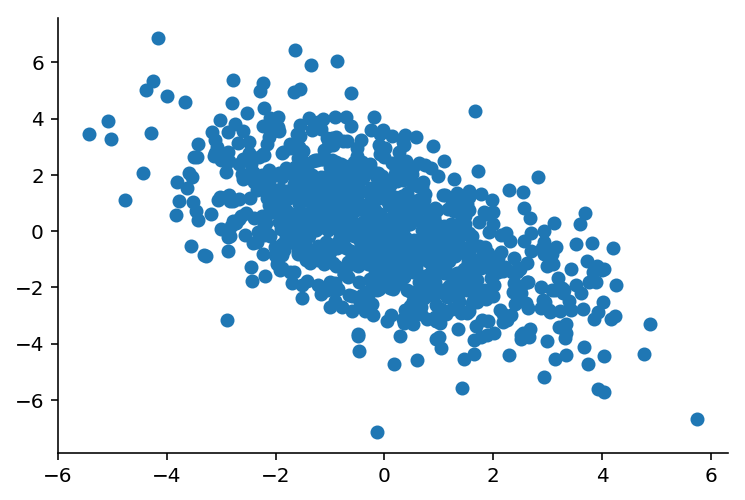

In [3]:
mu1 = 0
mu2 = 0
sig11 = 3.0
sig12 = -2.0
sig21 = -2.0
sig22 = 4.0

mean = cp.array([mu1, mu2])
cov = cp.array([[sig11, sig12], [sig21, sig22]])
draws = cp.random.multivariate_normal(mean, cov, size=1000)
plt.scatter(*np(draws.T))

One of the fundamental properties of Gaussians is that if you have a Multivariate Gaussian (e.g. a joint distribution of 2 or more Gaussian random variables), if we condition on any subset of Gaussians, the joint distribution of the rest of the Gaussians can be found analytically. There's a formula, and it's expressed in code below.

In [4]:
x1 = 0
mu_2g1 = mu2 + sig21 * 1 / sig11 * (x1 - mu1)
sig_2g1 = sig22 - sig21 * 1 / sig11 * sig12
mu_2g1, sig_2g1

(0.0, 2.666666666666667)

Go ahead and play with the slider below.

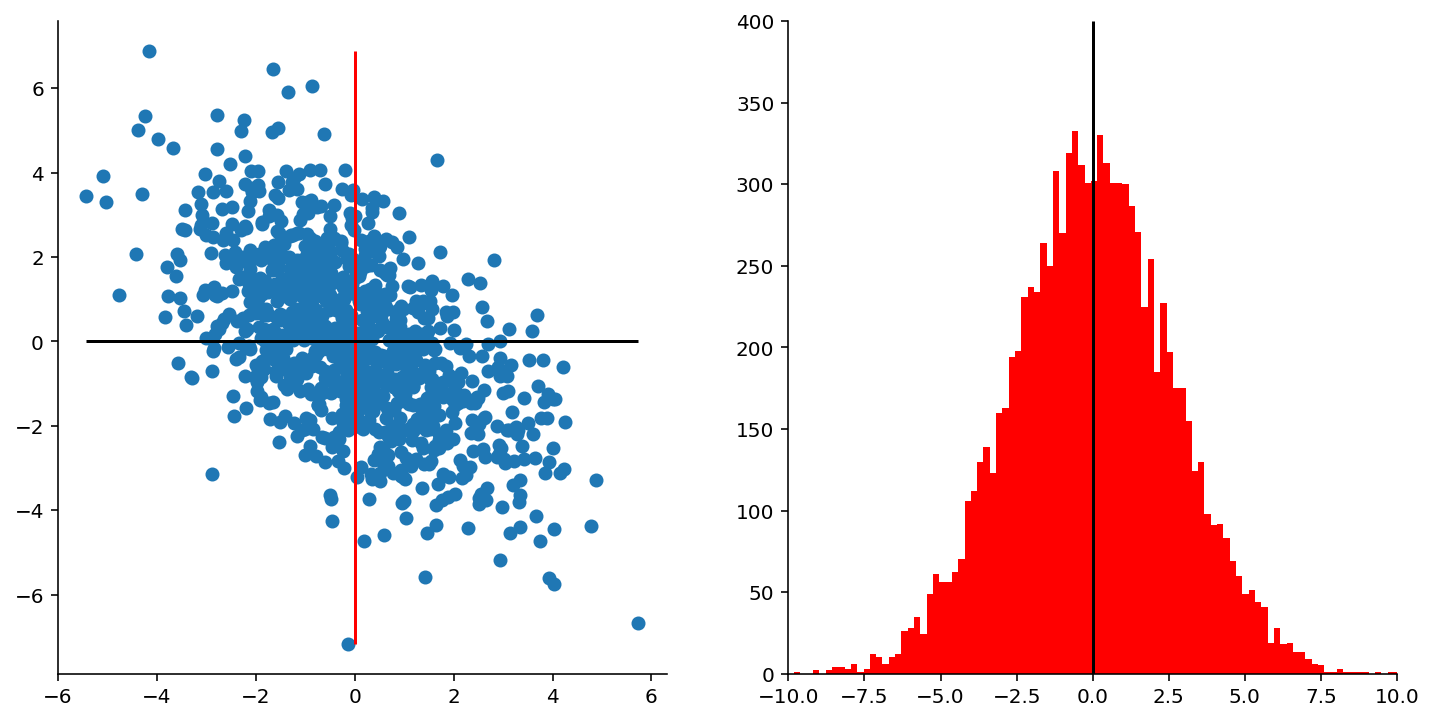

In [5]:
from ipywidgets import interact, FloatSlider, IntSlider

@interact(x1=FloatSlider(min=-4, max=4, continuous_update=False))
def plot_conditional(x1):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    axes[0].scatter(*np(draws.T))
    axes[0].vlines(x=x1, ymin=draws[:, 1].min(), ymax=draws[:, 1].max(), color='red')
    axes[0].hlines(y=0, xmin=draws[:, 0].min(), xmax=draws[:, 0].max(), color='black')
    
    # Compute Conditional
    mu_2g1 = mu2 + sig21 * 1 / sig11 * (x1 - mu1)
    sig_2g1 = sig22 - sig21 * 1 / sig11 * sig12
    x2_draws = cp.random.normal(mu_2g1, sig_2g1, size=10000)
    axes[1].hist(np(x2_draws), bins=100, color='red')
    axes[1].vlines(x=0, ymin=0, ymax=400, color='black')
    axes[1].set_xlim(-10, 10)
    axes[1].set_ylim(0, 400)

# Implementing GP Prior

When we use a GP, we're essentially modelling the **outputs** as being described by a joint Gaussian distribution. 

We would like to be able to specify the covariance matrix as a function of the distances between the inputs - regardless of whether the inputs are 1-D, 2-D, or more. That is the key to generalizing from 1D examples to the 2D examples commonly shown.

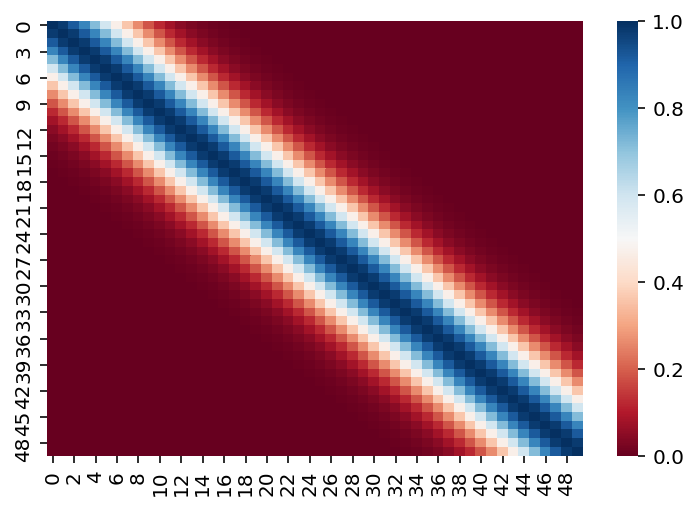

In [6]:
import seaborn as sns

n = 50
x_train = cp.linspace(-5, 5, n).reshape(-1, 1)

# sns.heatmap(x_train - x_train.T, cmap='RdBu')

def sq_exp(x1, x2):
    """
    Squared exponential kernel.
    
    Assumes that x1 and x2 have the same shape.
    """
    diff = x1 - x2.T
    sqdiff = cp.power(diff, 2)
    return cp.exp(-0.5 * sqdiff)



sns.heatmap(np(sq_exp(x_train, x_train)), cmap='RdBu')

Draw from prior.

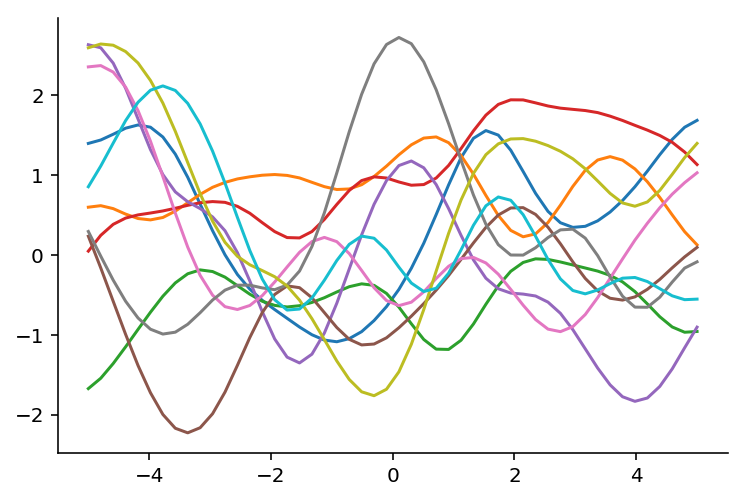

In [7]:
K = sq_exp(x_train, x_train)
eps = 1E-6 * cp.eye(n)  # 
L = cp.linalg.cholesky(K + eps)

f_prior = cp.dot(L, cp.random.normal(size=(n, 10)))
plt.plot(np(x_train), np(f_prior))
plt.show()

/home/ericmjl/anaconda/envs/bayesian/lib/python3.6/site-packages/cupy/random/distributions.py:373: FutureWarning: cupy.random.multivariate_normal is experimental. The interface can change in the future.
  util.experimental('cupy.random.multivariate_normal')
/home/ericmjl/anaconda/envs/bayesian/lib/python3.6/site-packages/cupy/random/generator.py:246: FutureWarning: cupy.random.RandomState.multivariate_normal is experimental. The interface can change in the future.
  util.experimental('cupy.random.RandomState.multivariate_normal')


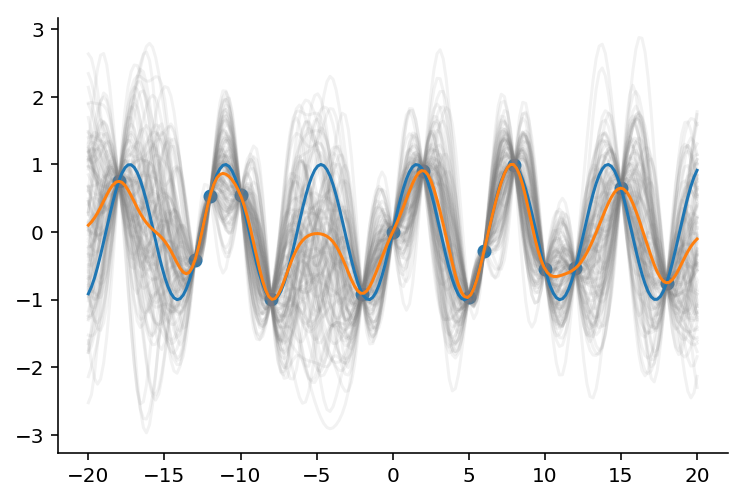

In [8]:
def true_function_1d(x):
    x = x + 1E-10
    return cp.sin(x)

n = 200
x_samp = cp.array([2, 18, -10, 10, -12, 12, -2, 5, -13, 6, -18, 8, -8, 0, 15]).reshape(-1, 1)
f_samp = true_function_1d(x_samp)
K_samp = sq_exp(x_samp, x_samp)
eps = 1E-6 * cp.eye(len(x_samp))
L_samp = cp.linalg.cholesky(K_samp + eps)

x_s = cp.linspace(-20, 20, n).reshape(-1, 1)
K_ss = sq_exp(x_s, x_s)
K_s = sq_exp(x_samp, x_s)

mu_cond = K_s.T @ cp.linalg.inv(K_samp) @ f_samp
sig_cond = K_ss - K_s.T @ cp.linalg.inv(K_samp) @ K_s

f_posterior = cp.random.multivariate_normal(mu_cond.flatten(), sig_cond, size=100)

for f in f_posterior:
    plt.plot(np(x_s), np(f), color='grey', alpha=0.1)
plt.scatter(np(x_samp), np(f_samp))
plt.plot(np(x_s), np(true_function_1d(x_s)))
plt.plot(np(x_s), np(mu_cond.flatten()))
plt.show()

In [9]:
sig_cond.min()

array(-0.24937572)

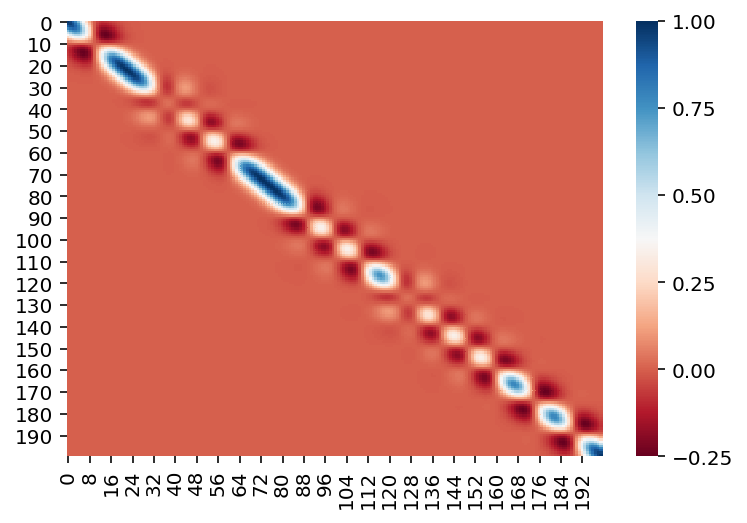

In [10]:
sns.heatmap(np(sig_cond), cmap='RdBu')

We can rewrite extend this code to apply in two dimensions. Let's say that our data lived on a grid, rather than on a single dimension. A periodic function is applied on a 2D grid.

In [11]:
def true_function(x1, x2):
    return cp.sin(x1) + cp.sin(x2)

# Prior

Let's sample a prior from a 2D plane.

In [12]:
sq_exp??

Signature: sq_exp(x1, x2)
Source:   
def sq_exp(x1, x2):
    """
    Squared exponential kernel.
    
    Assumes that x1 and x2 have the same shape.
    """
    diff = x1 - x2.T
    sqdiff = cp.power(diff, 2)
    return cp.exp(-0.5 * sqdiff)
File:      ~/github/incubator/bayesian-analysis-recipes/notebooks/<ipython-input-6-7bf2b9a5c5fa>
Type:      function


In [13]:
import scipy

In [14]:
x1 = cp.array([[2, 2], [2, 1], [1, 2], [1, 1]])

def sq_exp2d(x1, x2):
    d = scipy.spatial.distance.cdist(np(x1), np(x2))
    return cp.exp(-0.5 * cp.power(cp.array(d), 2))

Text(0.5, 1.0, 'true function')

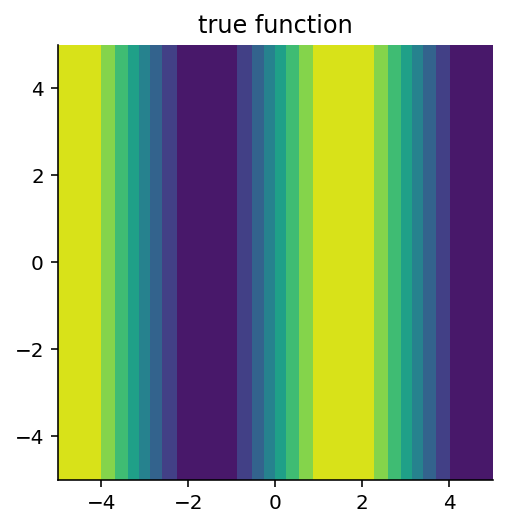

In [15]:
x1 = cp.linspace(-5, 5, 20)
x2 = cp.linspace(-5, 5, 20)
xx1, xx2 = cp.meshgrid(x1, x2, )
z = true_function(xx1, xx1)
h = plt.contourf(np(x1), np(x2), np(z))
plt.gca().set_aspect('equal')
plt.title('true function')

In [16]:
true_function(xx1, xx2).shape

(20, 20)

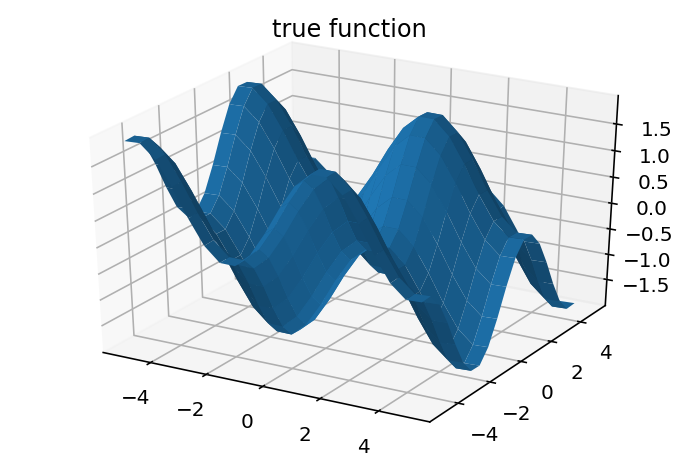

In [17]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
z = true_function(xx1, xx2)
ax.plot_surface(np(xx1), np(xx2), np(z))
ax.set_title('true function')
plt.show()

We'll simulate sampling 5 starting points.

In [18]:
x_samp = cp.array([[0, 3], [1, 2], [1, -5], [-2, -2], [-2, 2], [2, -2], [3, 5]])

f_samp = true_function(x_samp[:, 0], x_samp[:, 1])

K_samp = sq_exp2d(x_samp, x_samp)

eps = 1E-6 * cp.eye(len(x_samp))
L_samp = cp.linalg.cholesky(K_samp + eps)

n = 35
x_points = cp.linspace(-5, 5, n)
xx1, xx2 = cp.meshgrid(x_points, x_points)
x_spts = cp.vstack([xx1.flatten(), xx2.flatten()])
K_ss = sq_exp2d(x_spts.T, x_spts.T)
K_s = sq_exp2d(x_samp, x_spts.T)

mu_cond = K_s.T @ cp.linalg.inv(K_samp) @ f_samp.flatten()
sig_cond = K_ss - K_s.T @ cp.linalg.inv(K_samp) @ K_s

n_samps = 1000
f_posterior = cp.random.multivariate_normal(mu_cond, sig_cond, size=n_samps)

# for f in f_posterior:
#     plt.plot(x_s, f, color='grey', alpha=0.1)
# plt.scatter(x_samp, f_samp)
# plt.plot(x_s, true_function(x_train))
# plt.plot(x_s, mu_cond.flatten())

In [19]:
f_posterior.reshape(n_samps, n, n).max(axis=0)

array([[4.27586471, 4.30854935, 4.10168091, ..., 2.89939148, 3.15387324,
        3.0982649 ],
       [3.62069371, 3.62053667, 3.5070464 , ..., 2.67924134, 2.88275506,
        2.93989639],
       [2.8661174 , 2.98728508, 2.97213582, ..., 2.80295879, 2.83508735,
        2.94036126],
       ...,
       [3.02736874, 3.30774943, 3.36898253, ..., 3.01323363, 2.90791344,
        3.07647519],
       [3.31334418, 3.50261287, 3.47812582, ..., 2.79014652, 3.11133838,
        3.24603455],
       [3.44680785, 3.50221592, 3.35201159, ..., 2.52912071, 3.1934669 ,
        3.43466632]])

In [20]:
mu_cond.shape

(1225,)

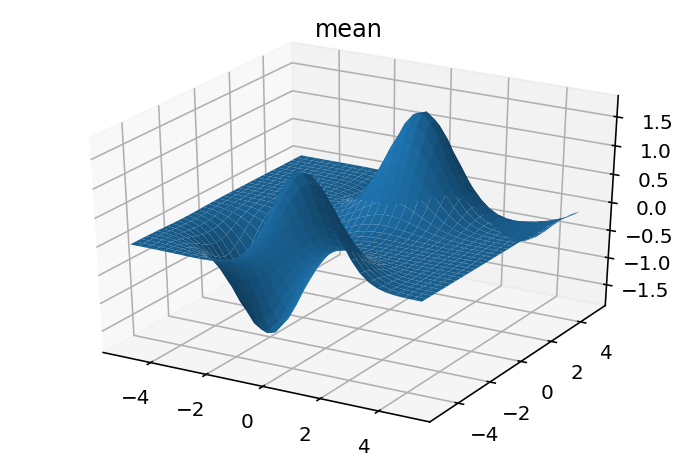

In [21]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(np(xx1), np(xx2), np(mu_cond.reshape(n, n)))
ax.set_title('mean')
plt.show()

In [22]:
lower, upper = cp.percentile(f_posterior.reshape(n_samps, n, n), [2.5, 97.5], axis=0)
uncertainty = upper - lower

In [23]:
uncertainty.shape

(35, 35)

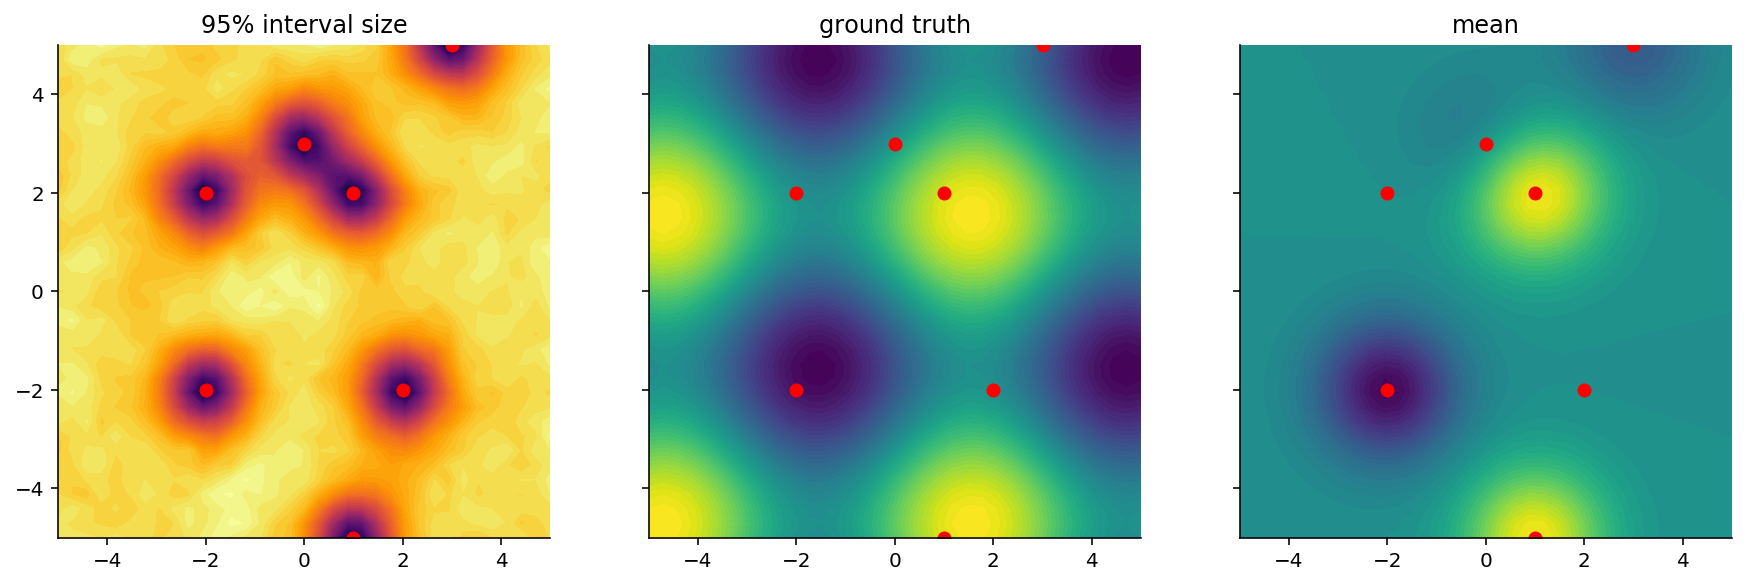

In [24]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5), sharex=True, sharey=True)
axes[0].contourf(np(xx1), np(xx2), np(uncertainty), levels=50, cmap='inferno')
axes[0].set_title('95% interval size')
axes[0].scatter(*np(x_samp.T), color='red')
axes[0].set_aspect('equal')
axes[0].set_ylim(-5, 5)
axes[0].set_xlim(-5, 5)

axes[1].contourf(np(xx1), np(xx2), np(true_function(xx1, xx2)), levels=50)
axes[1].set_title('ground truth')
axes[1].scatter(*np(x_samp.T), color='red')
axes[1].set_aspect('equal')

axes[2].contourf(np(xx1), np(xx2), np(mu_cond.reshape(n, n)), levels=50)
axes[2].set_title('mean')
axes[2].scatter(*np(x_samp.T), color='red')
axes[2].set_aspect('equal')

In the plot sabove, red dots mark where we have sampled points on the 2D grid. 

The left plot shows the size of the 95% prediction interval at each point on the grid. We can see that we have the smallest uncertainty where we have sampled.

The middle plot shows ground truth, and the values where we have sampled data.

The right plot shows the value of the mean where we have sampled. It is evident that where we do not have better data, the function evaluations default to the mean function.

# Parting Thoughts

The key ingredient of a GP: A Kernel that can model "distance" of some kind between every pair of inputs. Thus, it isn't the number of dimensions that is limiting; it is the number of *data points that have been sampled* that is limiting! (Inversion of the matrix only depends on the data that we are conditioning on, and that is of order $O(n^3)$.)

In [25]:
x2_new, x1_new = cp.where(uncertainty == uncertainty.max())  # row, then column, i.e. x2 then x1.
xx1_s, xx2_s = cp.meshgrid(x_points, x_points)
xx1_s.flatten()[x1_new], xx2_s.flatten()[x2_new]

(array([-1.47058824]), array([-5.]))